#DT2470 Lab 03: Shazam Wow!

by Bob |. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

![fingerprint overview](https://drive.google.com/uc?id=1HcVCkvyhHrKEkvVemr7wufaTHws5FPG8)

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.


---



In [1]:
# Install a python library for working with audio files, named pydub
!pip install pydub

from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

root_path_lab03 = 'gdrive/My Drive/KTH/DT2470/Lab_03/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# Progress bar code
import time, sys
from IPython.display import clear_output

def update_progress(progress):
  bar_length = 20
  if isinstance(progress, int):
    progress = float(progress)
  if not isinstance(progress, float):
    progress = 0
  if progress < 0:
    progress = 0
  if progress >= 1:
    progress = 1
  block = int(round(bar_length * progress))
  clear_output(wait = True)
  text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
  print(text)


#Part 1 Creating audio fingerprints

1. Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


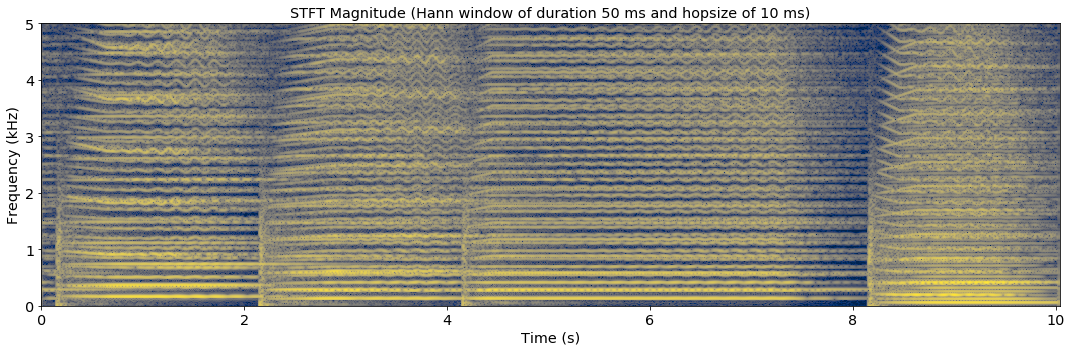

In [4]:
import pydub
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
# write code here
# Load sound samples and plot them ...
sound = pydub.AudioSegment.from_file(root_path_lab03 + 'Q1.wav', format='wav')
samples = sound.get_array_of_samples() # Return the raw audio data as an array of (numeric) samples
normalized_samples = [(ele/2**16.)*2 for ele in samples] # Normalize the 16-bit track, samples is now normalized [-1,1]
fs = sound.frame_rate # Get the sampling frequency

if sound.channels > 1:
  samples_l = normalized_samples[::2]   # Left channel
  samples_r = normalized_samples[1::2]  # Right channel
  samples = samples_l                   # We look at left channel
else:
  samples = normalized_samples

# STFT of the audio signal using Hann window of duration 50 ms and hopsize of 10 ms
window_duration = 0.050 # 50 ms
hop_size = 0.010        # 10 ms
zp_factor = 4           # Zeropadding to four times the length of the window.
f, t, Zxx = signal.stft(samples, fs, window='hann',
                        nperseg=window_duration*fs,
                        noverlap=(window_duration-hop_size)*fs,
                        nfft=zp_factor*window_duration*fs) # stft computing
samples_stft_dB = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))

plt.pcolormesh(t, f/1000, samples_stft_dB, vmin=-80, vmax=0, cmap='cividis')
plt.title('STFT Magnitude (Hann window of duration 50 ms and hopsize of 10 ms)')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.ylim([0,5])
plt.tight_layout()
plt.show()


2. We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [0]:
def locate_anchors(f, t, Zxx, At = 0.1, f_nsegm = 25):
  t_nsegm = np.floor(t[-1]/At).astype(int) # Get number of time segments
  Af = ((fs/2)/f_nsegm) # Divide the spectrum [0 Fs/2] into 25 bands

  anchors = np.zeros([f_nsegm,t_nsegm])

  f_max_idx = []
  t_max_idx = []
  for band in range(0,f_nsegm):
    for n in range(0,t_nsegm):
      # Time and freq segment where we look for the max value
      f_segm = (f >= band*Af) & (f < (band+1)*Af)
      t_segm = (t >= n*At) & (t < (n+1)*At)
      t_segm_idx = np.asarray(np.where(t_segm == 1))
      f_segm_idx = np.asarray(np.where(f_segm == 1))

      stft_tmp = np.zeros([np.size(f_segm_idx,1),np.size(t_segm_idx,1)])
      for ti in range(0,t_segm_idx.shape[1]):
        stft_tmp[:,ti] = Zxx[f_segm_idx,t_segm_idx[0,ti]]

      anchors[band,n] = np.max(stft_tmp)
      ind = np.asarray(np.unravel_index(np.argmax(stft_tmp), stft_tmp.shape))
      f_max_idx.append(f_segm_idx[0,ind[0]])
      t_max_idx.append(t_segm_idx[0,ind[1]])
      f_anchors = f[f_max_idx]
      t_anchors = t[t_max_idx]
  return anchors, f_anchors, t_anchors

In [0]:
At = 0.1 # 100 ms
f_nsegm = 25 # 25 bands
anchors, f_anchors, t_anchors = locate_anchors(f, t, samples_stft_dB, At, f_nsegm)

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x". ![My scatter plot](https://drive.google.com/uc?id=1sGi29bcTNN7f8NtZ4tjlS6MDUf_fXhcw)

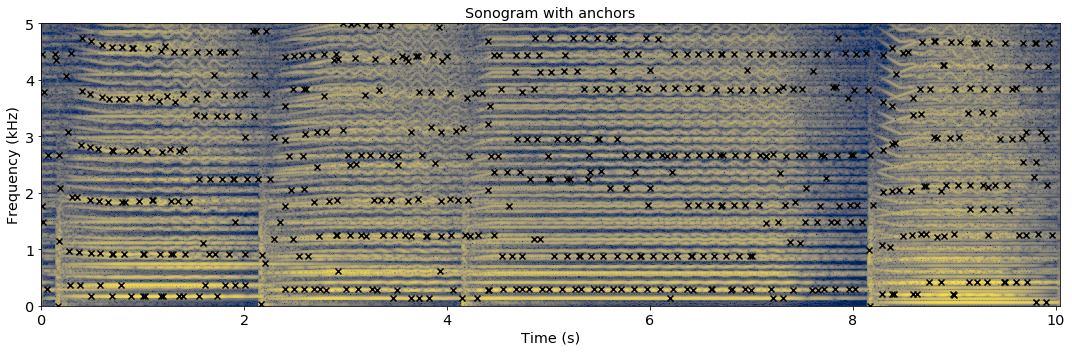

In [11]:
# plot
fig, ax = plt.subplots()
plt.pcolormesh(t, f/1000, samples_stft_dB, vmin=-80, vmax=0, cmap='cividis')
plt.scatter(t_anchors, f_anchors/1000, c='black', marker="x")
plt.title('Sonogram with anchors')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
ax.set_xlim(left=0, right=np.max(t))
plt.ylim([0,5])
plt.tight_layout()
plt.show()

This new set of anchors represent the sonogram in a simpler way, where the amplitude is no longer relevant, and frequency and time represent each point of the plot. Before the anchor locating algorithm, there were $4,411·1,005=4,433,055$ different values but now there are $25·100=2,500$ points, hence we have reduced the complexity of the initial problem by a factor of $1,773.2$.

With all these points we will be able to compute hashes and build the fingerprint of an audio file.


4. Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [0]:
class hash:
  def __init__(self, f1, f2, t1, t2):
    self.f1 = f1          # Frequency anchor 1
    self.f2 = f2          # Frequency anchor 2
    self.A_t1t2 = t2 - t1 # Difference in their time positions 


def compute_hashes(t_anchors, f_anchors):
  time_target_zone = np.array([0.1, 0.5])
  freq_target_zone = np.array([2**-0.5, 2**0.5])
  
  hashes = []
  hashes_time = []
  fingerprint = []
  for n in range(t_anchors.size):
    t1 = t_anchors[n]
    f1 = f_anchors[n]

    for m in range(t_anchors.size):
      t2 = t_anchors[m]
      f2 = f_anchors[m]
      t_zone = (t2 >= t1+time_target_zone[0]) and (t2 < t1+time_target_zone[0]+time_target_zone[1]) # Check time zone
      f_zone = (f2 >= f1*freq_target_zone[0]) and (f2 < f1*freq_target_zone[1]) # Check frequency zone
    
      if(t_zone and f_zone): # Check if it is in targuet zone
        h = hash(f1,f2,t1,t2)
        hashes.append(h)
        hashes_time.append(t1)
        fingerprint.append({t1:h})
  return fingerprint

In [0]:
F = compute_hashes(t_anchors, f_anchors) # Get fingerprint

#Part 2 Comparing fingerprints

5. Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)+(b-e)+(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this:

 ![My scatter plot](https://drive.google.com/uc?id=1nIwTLYPFM64VAkt8hsfG9WMiXzFNAJjq) 



In [0]:
def fingerprint_comparing(F1, F2):
  F1_match = []
  F2_match = []
  count = 0
  for i in F1:
      count+=1
      update_progress(count / len(F1))
      #print(str(count)+'/'+str(len(F1)))
      F1_time = list(i.keys())[0]
      F1_f1 = i[F1_time].f1
      F1_f2 = i[F1_time].f2
      F1_At1t2 = i[F1_time].A_t1t2
      for j in F2:
        F2_time = list(j.keys())[0]
        F2_f1 = j[F2_time].f1
        F2_f2 = j[F2_time].f2
        F2_At1t2 = j[F2_time].A_t1t2
        d = abs((F1_f1-F2_f1)+(F1_f2-F2_f2)+(F1_At1t2-F2_At1t2))
        if d == 0:
          F1_match.append(F1_time)
          F2_match.append(F2_time)
  return F1_match, F2_match

In [0]:
# Load the audio file
sound = pydub.AudioSegment.from_file(root_path_lab03 + 'Q1.wav', format='wav')
samples = sound.get_array_of_samples() # Return the raw audio data as an array of (numeric) samples
normalized_samples = [(ele/2**16.)*2 for ele in samples] # Normalize the 16-bit track, samples is now normalized [-1,1]
fs = sound.frame_rate # Get the sampling frequency
if sound.channels > 1:
  samples_l = normalized_samples[::2]   # Left channel
  samples_r = normalized_samples[1::2]  # Right channel
  samples = samples_l                   # We look at left channel
else:
  samples = normalized_samples

# Extract a fragment from the audio file
fragment_time = 1 
fragment_time_offset = 0
fragment = samples[int(fs*fragment_time_offset):int(fs*(fragment_time_offset+fragment_time))]

# STFT of the fragment using Hann window of duration 50 ms and hopsize of 10 ms
window_duration = 0.050 # 50 ms
hop_size = 0.010        # 10 ms
zp_factor = 4           # Zeropadding to four times the length of the window.
f_query, t_query, Zxx_query = signal.stft(fragment, fs, window='hann',
                        nperseg=window_duration*fs,
                        noverlap=(window_duration-hop_size)*fs,
                        nfft=zp_factor*window_duration*fs) # stft computing
fragment_stft_dB = 20*np.log10(np.abs(Zxx_query)/np.max(np.abs(Zxx_query)))

# Locate anchors
At = 0.1 # 100 ms
f_nsegm = 25 # 25 bands
anchors_query, f_anchors_query, t_anchors_query = locate_anchors(f_query, t_query, fragment_stft_dB, At, f_nsegm)
F_query = compute_hashes(t_anchors_query, f_anchors_query) # Get fingerprint query

In [16]:
F1_match, F2_match = fingerprint_comparing(F_query,F_query)

Progress: [####################] 100.0%


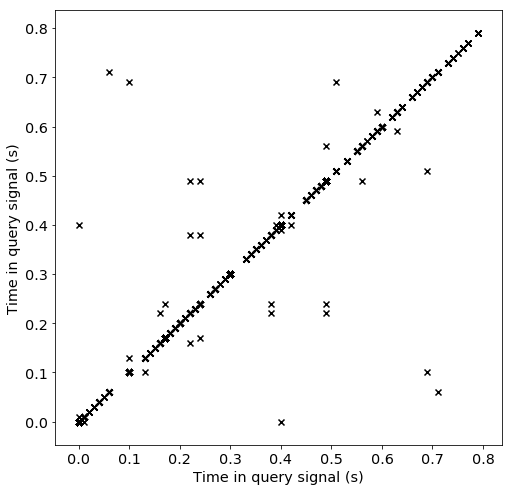

In [17]:
params = {'figure.figsize': (8,8)}
plt.rcParams.update(params)
plt.scatter(F1_match, F2_match,c='black', marker="x")
plt.xlabel('Time in query signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

As we can see in the figure above, after running the designed algorithm, there were found several matches between both fingerprints, and the vast majority of them are drawing a line on the graph. When a line occurs, it means that both files are most likely to be the same, at least at that fragment of time. Moreover, we are able to see that the points are symmetrical since we are comparing the same fingerprint query.

6. Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [18]:
# write code here
F1_match_query, F2_match_original = fingerprint_comparing(F_query,F)

Progress: [####################] 100.0%


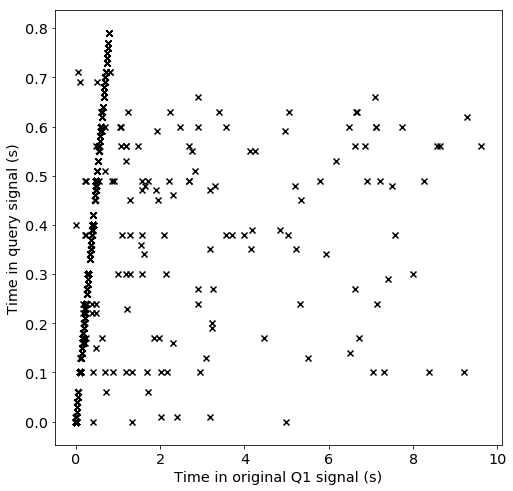

In [19]:
plt.scatter(F2_match_original,F1_match_query, c='black', marker="x")
plt.xlabel('Time in original Q1 signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

As expected, the line goes now from zero to one second, since the fingerprint query is just a one-second fragment of the file Q1.wav.

7. Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

In [0]:
# Load the audio file
sound = pydub.AudioSegment.from_file(root_path_lab03 + 'Q2.wav', format='wav')
samples = sound.get_array_of_samples() # Return the raw audio data as an array of (numeric) samples
normalized_samples = [(ele/2**16.)*2 for ele in samples] # Normalize the 16-bit track, samples is now normalized [-1,1]
fs = sound.frame_rate # Get the sampling frequency
if sound.channels > 1:
  samples_l = normalized_samples[::2]   # Left channel
  samples_r = normalized_samples[1::2]  # Right channel
  samples = samples_l                   # We look at left channel
else:
  samples = normalized_samples

# STFT of the fragment using Hann window of duration 50 ms and hopsize of 10 ms
window_duration = 0.050 # 50 ms
hop_size = 0.010        # 10 ms
zp_factor = 4           # Zeropadding to four times the length of the window.
f_d, t_d, Zxx_d = signal.stft(samples, fs, window='hann',
                        nperseg=window_duration*fs,
                        noverlap=(window_duration-hop_size)*fs,
                        nfft=zp_factor*window_duration*fs) # stft computing
samples_stft_dB = 20*np.log10(np.abs(Zxx_d)/np.max(np.abs(Zxx_d)))

# Locate anchors
At = 0.1 # 100 ms
f_nsegm = 25 # 25 bands
anchors_d, f_anchors_d, t_anchors_d = locate_anchors(f_d, t_d, samples_stft_dB, At, f_nsegm)
F_d = compute_hashes(t_anchors_d, f_anchors_d) # Get fingerprint query

In [21]:
F1_match_query, F2_match_another = fingerprint_comparing(F_query,F_d)

Progress: [####################] 100.0%


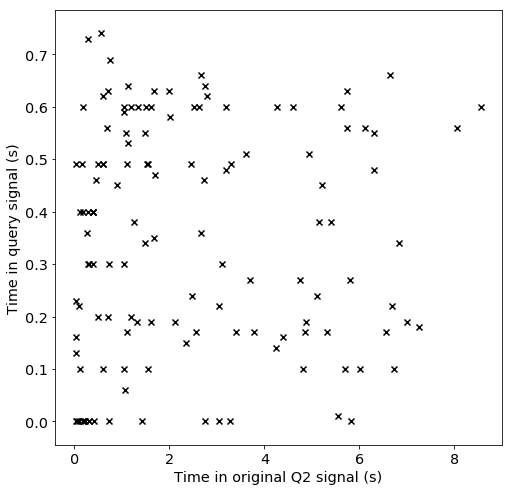

In [22]:
plt.scatter(F2_match_another,F1_match_query, c='black', marker="x")
plt.xlabel('Time in original Q2 signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

Finally, after comparing two different sound files, we can see that there is no line on this graph because there were no matches found linearly over time. Thus the system should not detect the Q2 signal as a possible candidate for the query sound file.